# NBA Game Predictor Model
With the emergence of the importance of analytics in the NBA in the past few seasons, I wondered whether it would be possible to predict the outcome of NBA games with these new advanced analytics. Based on research, I decided to use team statistics such as Offensive Rating, Defensive Rating, Net Rating, Percentage of Field Goals Assisted, Assist to Turnover Ratio, Offensive Rebound Percentage, Defensive Rebound Percentage, Total Rebound Percentage Turnover Percentage, Effective Field Goal Percentage, True Shooting Percentage, Pace, and Player Impact Estimate with various classifying algorithms to see if I could predict the outcomes of games in previous seasons. The data used in this project was scraped from https://www.basketball-reference.com/ and https://nba.com/stats.

## Import Statements
These are all the libraries I use for this project. Numpy, pandas, seaborn, and matplotlib are used to structure and visualize data, and the rest are used to perform the classification algorithms

In [6]:
import numpy as np 
import pandas as pd 
# from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

## Data Retrieval and Modification
The first step was to retrieve all the data and clean it up so it can be used efficiently. All game data was scraped and put into .csv files, separated by season, and all statistics for teams were also scraped and put into .csv files, separated by season. Data from the 2017-2018 and 2018-2019 season is used for training, and data from the 2019-2020 season is used as the testing data. Data for 2019-2020 season is all pre-COVID to keep the conditions of games the same.

In [7]:

#2017-2018 and 2018-2019 game data is put into data frames

df_2017_game = pd.read_csv('2017-18GameData.csv')
df_2018_game = pd.read_csv('2018-19GameData.csv')
print(df_2017_game.head())

               Team1  Team1PTS                  Team2  Team2PTS
0     Boston Celtics        99    Cleveland Cavaliers       102
1    Houston Rockets       122  Golden State Warriors       121
2  Charlotte Hornets        90        Detroit Pistons       102
3      Brooklyn Nets       131         Indiana Pacers       140
4         Miami Heat       109          Orlando Magic       116


In [23]:
#2017-2018 and 2018-2019 statistics are put into data frames
df_2017_stats = pd.read_csv('2017-18Stats.csv')
df_2018_stats = pd.read_csv('2018-19Stats.csv')

#Team statistical data and game data are merged into one data frame. For each given game, Team1 is the away team and
#Team2 is the home team. The data frames are merged so that for each given game, Team1's and Team2's stats are both
#given, and the outcome, whether Team1, the away team, wins or not is also given.
conditions = [
    df_2017_game['Team1PTS'] > df_2017_game['Team2PTS'],
    df_2017_game['Team1PTS'] < df_2017_game['Team2PTS']
]

choices=[1,0]

df_2017_game['Team1Win'] = np.select(conditions, choices, 1)

# Mergings the results and stats datasets, adding a prefix depending on which teams stats are being used
df = df_2017_game.merge(df_2017_stats.add_prefix('Team1'), how='left', left_on=['Team1'], 
                   right_on=['Team1TEAM']).drop(['Team1TEAM'],
                                                axis=1).merge(df_2017_stats.add_prefix('Team2'), 
                                                                            how='left', left_on=['Team2'], 
                                                                            right_on=['Team2TEAM']).drop(['Team2TEAM'],axis=1)
conditions = [
    df_2018_game['Team1PTS'] > df_2018_game['Team2PTS'],
    df_2018_game['Team1PTS'] < df_2018_game['Team2PTS']
]

choices=[1,0]

df_2018_game['Team1Win'] = np.select(conditions, choices, 1)

# Mergings the results and stats datasets, adding a prefix depending on which teams stats are being used
df_2018 = df_2018_game.merge(df_2018_stats.add_prefix('Team1'), how='left', left_on=['Team1'], 
                   right_on=['Team1TEAM']).drop(['Team1TEAM'],
                                                axis=1).merge(df_2018_stats.add_prefix('Team2'), 
                                                                            how='left', left_on=['Team2'], 
                                                                           right_on=['Team2TEAM']).drop(['Team2TEAM'],axis=1)
#Unnecessary team stats are removed from the data.
del df['Team1GP']
del df['Team1W']
del df['Team1L']
del df['Team1MIN']
del df['Team2GP']
del df['Team2W']
del df['Team2L']
del df['Team2MIN']
del df_2018['Team1GP']
del df_2018['Team1W']
del df_2018['Team1L']
del df_2018['Team1MIN']
del df_2018['Team2GP']
del df_2018['Team2W']
del df_2018['Team2L']
del df_2018['Team2MIN']
df.to_csv('2017Data.csv')
df_2018.to_csv('2018Data.csv')
print(df_2018)

                       Team1  Team1PTS                   Team2  Team2PTS  \
0         Philadelphia 76ers        87          Boston Celtics       105   
1      Oklahoma City Thunder       100   Golden State Warriors       108   
2            Milwaukee Bucks       113       Charlotte Hornets       112   
3              Brooklyn Nets       100         Detroit Pistons       103   
4          Memphis Grizzlies        83          Indiana Pacers       111   
...                      ...       ...                     ...       ...   
1225           Chicago Bulls       109      Philadelphia 76ers       125   
1226        Dallas Mavericks        94       San Antonio Spurs       105   
1227  Minnesota Timberwolves        95          Denver Nuggets        99   
1228               Utah Jazz       137    Los Angeles Clippers       143   
1229        Sacramento Kings       131  Portland Trail Blazers       136   

      Team1Win  Team1OFFRTG  Team1DEFRTG  Team1NETRTG  Team1AST%  Team1AST/TO  \
0     

Now that we have all game data and team data merged, the data is one step closer to being ready to be used for modeling. For the purposes of this project, we won't need the points data for each game either, as we are output is simply whether the away team wins or not, so we drop the points data for both reams. Then, the 2017 and 2018 data are stacked on top of one another so that they are one huge data frame.

In [9]:
#check if there are any holes in the data
print(df.size)
df = df.replace(-np.inf,np.nan)
df = df.replace(np.inf,np.nan)
df = df.replace(np.nan,0)
print(df.size)
df_no_pts = df.drop(['Team1PTS','Team2PTS'],1)
df_2018_no_pts = df_2018.drop(['Team1PTS','Team2PTS'],1)
#stacks the two dataframes on top of one another to create the training data set.
df_total_train = pd.concat([df_no_pts,df_2018_no_pts],axis = 0)
df_total_train.to_csv('totalData.csv')

40590
40590


In [10]:
#For the purposes of training and predicting, the team names of each team are also not useful
df_train = df_total_train.drop(['Team1','Team2'],1)
print(df_train.head())

   Team1Win  Team1OFFRTG  Team1DEFRTG  Team1NETRTG  Team1AST%  Team1AST/TO  \
0         0        106.8        103.2          3.6       58.6         1.60   
1         1        114.1        105.7          8.4       55.7         1.56   
2         0        109.0        109.0         -0.1       55.4         1.70   
3         0        106.1        109.7         -3.6       61.9         1.56   
4         0        106.2        105.8          0.4       58.5         1.58   

   Team1AST RATIO  Team1OREB%  Team1DREB%  Team1REB%  ...  Team2AST/TO  \
0            17.0        26.3        73.9       50.4  ...         1.70   
1            16.4        25.4        75.0       50.3  ...         1.90   
2            16.1        27.1        76.3       51.2  ...         1.70   
3            17.3        25.1        73.1       48.9  ...         1.67   
4            17.1        26.1        74.1       50.1  ...         1.61   

   Team2AST RATIO  Team2OREB%  Team2DREB%  Team2REB%  Team2TOV%  Team2EFG%  \
0       

## Data Exploration
Now, using the seaborn library, we can see how each of the statistics are related with each other with a heatmap. The bright diagonal strip shows us each stat is directly correlated to itself, basically telling us thi is working properly. We can also see that because the top left and bottom right quadrants are the most colorful, and the top right and bottom left quadrant are generally around the color for 0, a team's stats strongly correlate to itself, and do not correlate at all to the other team's stats. We also see in the top row that there isn't any single statistic that is strongly correlated to Team 1 winning. 

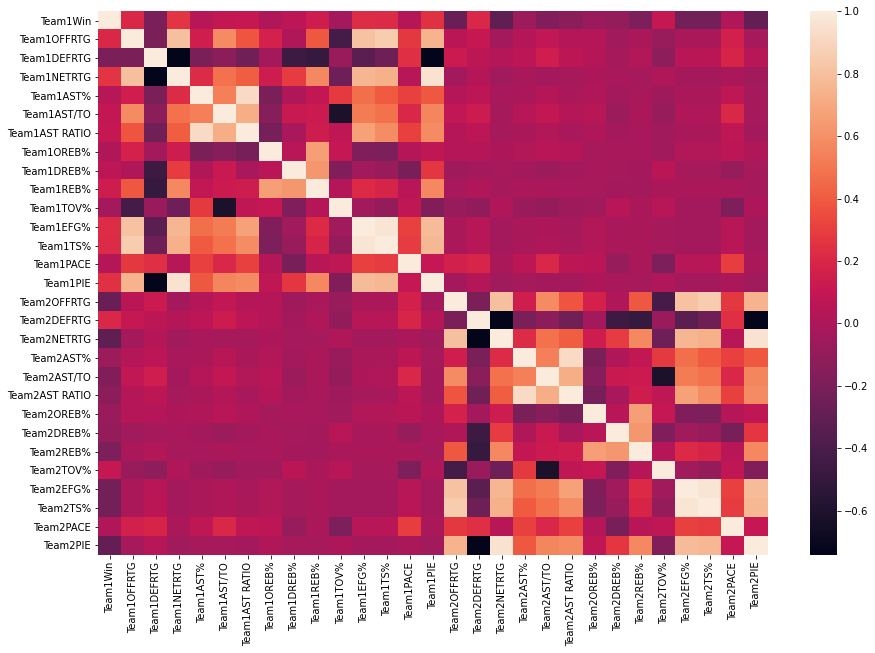

In [11]:
corr = df_train.corr() #creates a correlation matrix of all features
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr,xticklabels=True, yticklabels=True) #display the heatmap

If we also plot the amount of times that Team 1 (the away team) wins and loses, we see that it loses more often than it wins, illustrating the effect of homecourt advantage

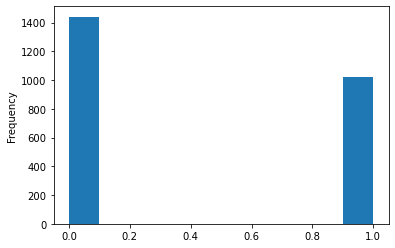

In [12]:
df_train['Team1Win'].plot.hist()

In [13]:
df_train.to_csv('TrainingData.csv')


## Testing different models
Now that we have the data formatted correctly, we can put the data through various models to determine the accuracy of different models.

In this function, we pass in a training data set and a testing data set. We use the training data set to fit the model and adjust its parameters, and the testing data is used to test the accuracy of the model. the parameter 'shuffles', determines whether we shuffle the training and testing data to add more randomness to the model. The 'num_neighbors' parameter is used to determine the number of neighbors for the knn classifier. The models that this function tests are K-Nearest Neighbors, Support Vector Machine, Bagging Classifier, and Random Forest Classifier

In [14]:
def test_Predictions(train, test,shuffles = True,num_neighbors = 15):
    """
    Function to test the accuracy of various classifying models on predicting the outcomes of NBA games using statistics of both teams
    
    Args:
        - train: the training dataset. The dataset that is used to fit the model.
        - test: the testing dataset. The dataset that is used to test the accuracy of the model
        - shuffles: whether or not the datasets will be shuffled/randomized
        - num_neighbors: the number of nearest neighbors used for K-Nearest Neighbors Classifier
    Return:
        - None
    """
    if(shuffles):
        train = train.sample(frac = 1)
        test = train.sample(frac = 1)
    X_train = train.drop(['Team1Win'],1)
    Y_train = train['Team1Win']
    X_test = test.drop(['Team1Win'],1)
    Y_test = test['Team1Win']
    knn = KNeighborsClassifier(n_neighbors = num_neighbors)
    knn.fit(X_train,Y_train)
    print('K Nearest Neighbors performance: ' + str(knn.score(X_test,Y_test)))
    svc = SVC(gamma = 'scale',probability= True)
    svc.fit(X_train, Y_train)
    print("Support Vector Machine performance: "+ str(svc.score(X_test, Y_test)))
    bag = BaggingClassifier(base_estimator=SVC(gamma = 'scale'),n_estimators = 10,random_state= 0)
    bag.fit(X_train,Y_train)
    print("Bagging Classifier performance: "+ str(bag.score(X_test,Y_test)))
    rfc = RandomForestClassifier(max_depth=8,random_state=10,n_estimators=300)
    rfc.fit(X_train,Y_train)
    print('Random Forest Classifier performance: ' + str(rfc.score(X_test, Y_test)))

Now we can test the models on the data we currently have. The data is split so that 75% of it is used for the training set and 25% is used for testing set. In our first test, we do not shuffle any of the data, and we use the defualt 15 nearest neighbors.

In [15]:
train, test = train_test_split(df_train, test_size = 0.25,shuffle = False) #splits data so 75% is training and 25% is testing
test_Predictions(train,test,False) #prints out the accuracy of each model

K Nearest Neighbors performance: 0.6813008130081301
Support Vector Machine performance: 0.6617886178861788
Bagging Classifier performance: 0.6585365853658537
Random Forest Classifier performance: 0.6552845528455284


From our results, we see that all four models perform around the same in terms of accuracy, ranging from ~65% - ~69%. The K-Nearest Neighbors model had the highest accuracy out of all the models, but not by a significant margin.



Now, we test the models on the same data, but the data will be shuffled to see if there is any effect:

In [16]:
train, test = train_test_split(df_train, test_size = 0.25,shuffle = True)
test_Predictions(train,test)

K Nearest Neighbors performance: 0.7111111111111111
Support Vector Machine performance: 0.6780487804878049
Bagging Classifier performance: 0.6715447154471544
Random Forest Classifier performance: 0.8227642276422764


From these results, we see that all four models performed better when the data is shuffled, showing that adding randomization helps improve the models. We see the range of accuracy is ~67% - ~82%, and the Random Forest Classifier performed the best out of the four models with an accuracy of ~82.1%


## Applying To New Data
Seeing as the randomized Random Forest Classifier performed the best out of all 8 situations, we will use this model to see if we can predict the records for the 2019-2020 before the season went into shutdown due to COVID using the 2017-2018 and 2018-2019 data as the training data.
First, we have to get the 2019-2020 data and format it just like we did for the rest of the data

In [17]:
df_2020_game = pd.read_csv('2019-20GameData.csv')
df_2020_stats = pd.read_csv('2019-20Stats.csv')

In [18]:
conditions = [
    df_2020_game['Team1PTS'] > df_2020_game['Team2PTS'],
    df_2020_game['Team1PTS'] < df_2020_game['Team2PTS']
]

choices=[1,0]

df_2020_game['Team1Win'] = np.select(conditions, choices, 1)

# Mergings the results and stats datasets, adding a prefix depending on which teams stats are being used
df_2020 = df_2020_game.merge(df_2020_stats.add_prefix('Team1'), how='left', left_on=['Team1'], 
                   right_on=['Team1TEAM']).drop(['Team1TEAM'],
                                                axis=1).merge(df_2020_stats.add_prefix('Team2'), 
                                                                            how='left', left_on=['Team2'], 
                                                                            right_on=['Team2TEAM']).drop(['Team2TEAM'],axis=1)
df_2020.to_csv('2020Data.csv')
df_2020 = df_2020.drop(['Team1GP', 'Team1W','Team1L','Team1MIN','Team2GP','Team2W','Team2L','Team2MIN'],1)
df_test = df_2020.drop(['Team1','Team2','Team1PTS','Team2PTS'],1)
test_Predictions(df_train,df_test,False)
test_Predictions(df_train,df_test)

K Nearest Neighbors performance: 0.6539649845520082
Support Vector Machine performance: 0.6725025746652935
Bagging Classifier performance: 0.6673532440782698
Random Forest Classifier performance: 0.6735324407826982
K Nearest Neighbors performance: 0.7142276422764228
Support Vector Machine performance: 0.6784552845528455
Bagging Classifier performance: 0.6780487804878049
Random Forest Classifier performance: 0.8032520325203252


We see again that the Random Forest Classifier with randomization performs the best out of all 8 situations.
Now we can use this information to fit and train a Random Forest Classifier with randmoized data from 2017-2019 games and use them to output predictions for the 2019-2020 season.

In [19]:
df_train = df_train.sample(frac = 1) #randomize the training data
df_test = df_test.sample(frac = 1) #randomize the testing data
X_Train = df_train.drop(['Team1Win'],1)
Y_Train = df_train['Team1Win']
X_Test = df_test.drop(['Team1Win'],1)
rfc = RandomForestClassifier(max_depth=8,random_state=10,n_estimators=300)
rfc.fit(X_Train,Y_Train) 
predictions = rfc.predict(X_Test)#output the predictions of the model


Now that we have the predicted outputs of each game stored, we can use these predictions to create a data frame to display the records of each team .

In [20]:
df_predicted_records = pd.DataFrame(columns=['Team','W','L'])#initialize an empty data frame
df_predicted_records

,Team,W,L


In [21]:
for i,x in enumerate(predictions):
    index = df_test.index[i] #get the index of the game to match with the index of the 2020 data frame
    team1 = df_2020['Team1'][index] #Gets the actual team name of team1 of the game
    team2 = df_2020['Team2'][index]#Gets the actual team name of team2 of the game
    if(not(team1 in list(df_predicted_records['Team']))): #if the team is not already in the data frame, add it to the dataframe
        df_predicted_records.loc[len(df_predicted_records.index)] = [team1, 0, 0]
    if(not(team2 in list(df_predicted_records['Team']))):
        df_predicted_records.loc[len(df_predicted_records.index)] = [team2, 0, 0]
    if(x == 0): #if team1 lost, add a loss to its record and a win to team2's record
        df_predicted_records['L'][df_predicted_records.index[df_predicted_records['Team'] == team1][0]]+=1
        df_predicted_records['W'][df_predicted_records.index[df_predicted_records['Team'] == team2][0]]+=1
    else:#if team1 won, add a win to its record and a loss to team2's record
        df_predicted_records['W'][df_predicted_records.index[df_predicted_records['Team'] == team1][0]]+=1
        df_predicted_records['L'][df_predicted_records.index[df_predicted_records['Team'] == team2][0]]+=1


In [22]:
df_predicted_records

,Team,W,L
0,Oklahoma City Thunder,46,18
1,Brooklyn Nets,27,37
2,San Antonio Spurs,33,30
3,Phoenix Suns,43,22
4,Houston Rockets,43,21
5,Los Angeles Lakers,43,20
6,Los Angeles Clippers,52,12
7,New Orleans Pelicans,19,45
8,Minnesota Timberwolves,12,52
9,Indiana Pacers,47,18


If we compare these standings to the actual standings (https://www.nba.com/stats/teams/advanced/?sort=TEAM_NAME&dir=-1&Season=2019-20&SeasonType=Regular%20Season), we see that it does not do a bad job with the middle of the pack teams; however, for teams far below average or far above average, the model, for the most part, will always sway towards giving the far above average teams the win and giving the far below average teams the loss. In other words, the model does not deal with extrema well, and it does not predict upsets as much as it should.

## Result Analysis
From the results, we saw that the Random Forest Classifier when the data was randomized performed the best, getting ~80% of the games correct, which is quite impressive, but it could be improved. For example, in a real season, many more upsets occur. This can be due to the fact that the better statistical team is the away team, the better statistical team is playing the second game of a back-to-back, making them more fatigued, or travelling factors. If a team is on a long road trip, and they have to travel a lot, they are more likely to be fatigued.

Another issue with these results is the fact that the data used to create the model makes it hard to use this model in future seasons. This is because statistics like these cannot be used during the early stages of a current season because the statistics will not be an accurate representation of the team. It would take a good amount of the season to retrieve data that would be an accurate representation of the average performance of the team. Another flaw would be the fact that the data is biased, as the statistics of the team already include all the performances of their games. This leads to a realization that it we may be better off using individual player data rather than team data to predict outcomes, especially since teams can change a lot more drastically during one offseason than a player.